# Title : Cubic Building with 2 rooms separated with a wall and a door

names: Céleste CHAMBON, Charlotte JACQUELINE , Ornella DANOWICZ

teacher: Christian GHIAUS

start of the project: 24/04/2023

last edit: 30/05/2023

## Introduction

The aim of this project is to simulate an example of thermal dynamic simulation of a building. We consider a 2 rooms cubic building with 6 identical two-layer walls, a window, air infiltration (Ventilation), and an indoor temperature control system (HVAC).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## I. Model

First, we are going to model our building (2 rooms separated by a wall with a door). After, we have to formulate the hypothesis for boundary conditions, choose the types of windows, doors, and walls.

The second step is to draw the thermal circuit (temperature nodes, flow-rate paths, thermal conductances for conduction, convection, long-wave radiation, advection, and P-controllers, sources of temperature and flow-rate).

Once this is done, we can compute all the values : thermal conductances and capacities, the incidence matrix A, the conductance matrix B, and the capacity matrix C of the system of Algebraic Differential Equations (DAE).
	
Finally, we write in Python the vectors of pointers to the temperature sources b, flow-rate sources f and outputs y.

### 1. Description of the building

![House](./figures/Figure1.PNG)
> Figure 1. doble ventilated rooms (6 two-layer walls and 1 glass window) equiped with an HVAC system which acts as a proportional controller.

The dimensions and surface areas of the building are:

In [2]:
#surface
l = 5                # m length of the cubic room
Sgw = Sd = l*2       # m² surface of the glass and the door
SLw = l**2 - Sgw     # m² surface of the Right Wall (insulated)
SMw = l**2 - Sd      # m² surface of the Middle Wall
SRw = l**2           # m² surface of the left Wall (insulated)
Sother = 4 *l**2     # m² surface of other wall which are insulated
Swall_tot = Sother +SRw +SMw +SLw
Sinsul_tot = Sother +SRw  +SLw
Swall_out =5*(l**2)
#thichness:
thi_g = thi_ins = 5e-2 #cm
thi_wall = thi_d = 10e-2 #cm

Hypothesis and building description : 

We considered a 2 room building. The two rooms are separated by a wall including a door. The 6 walls of the building are made of concrete with a thickness of 10 cm. On the left wall there is a glass window with a thickness of 5cm and a surface of 5 x 2 = 10 m2. On the walls, we considered a layer of insulation of 5 cm. We put a HVAC system acting as a proportional controller in the second room and a ventilation system. We considered that the ceiling and the 2 lateral walls are isolated. 

On the model there are temperature sources : T0, the outdoor atmospheric air, T1 the temperature of the indoor air of room 1 and T2 the temperature of the indoor air of room 2. There is also a HVAC system to have a setpoint temperature of Tsp = 10°C. Additionally, there is a ventilation system. The sun also is a source of temperature that is applied on the window and the left wall. 

### 2. Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) and the geometry (widths and surface areas) of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [4]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': thi_wall,
            'Surface': Swall_tot }

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': thi_ins,
              'Surface': Sinsul_tot}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': thi_g,
         'Surface': Sgw}

wood = {'Conductivity': 0.2,
         'Density': 600,
         'Specific heat': 2500,
         'Width': thi_d,
         'Surface': Sd}


### 3. Radiative properties


In [5]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### 4. Convection coefficients

Conventional values for the convection coeficients for indoor and outdoor convection in W/(m²⋅K) are:

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


## II. Thermal circuit


![thermal_circuit](./figures/FigureA.PNG)
> Figure 2. Thermal circuit for the 2-rooms cubic bulding shown in Figure 1.

Figure 2 shows the models of:

- Concrete & insulation walls: Left wall in red and noted LW, the middle wall and the door between the 2 rooms in gray noted respectively MD and D and the right wall in blue noted RW

- Glass window in green noted GW

- Ventilation in pink noted Vent

HVAC system in black noted HVAC


The ceiling is considered isolated. We neglected the capacities of the middle wall, the door and the window. 

The sources are:

- T0, the outdoor temperature, °C;

- Tisp  the setpoint temperature for the indoor air, °C;

- ΦSUN, the outdoor radiative heat flow rate, W;

- Φi, the indoor radiative heat flow rate, W;

- Φa, the absorbed radiative heat flow rate, W;


Left wall : 

- R0 and R4 are respectively the exterior and indoor convection resistances

- R1, C1 and R2a characterized the isolation layer (conduction resistances and capacity)

- R2b, C2 and R3 characterized the concrete layer (conduction resistances and capacity)


Glass window : 

- R6a and R8 are respectively the exterior and indoor convection resistances

- R6b, C6 and R7 characterized the glass layer (conduction resistances and capacity)

- R5a, R5b, R5c represents the radiation resistances on the different surfaces


Middle wall and door : 

- R9a and R9b are respectively the middle wall and door convection + conduction resistances


Right wall : 

- R10a and R12b are respectively the indoor and exterior convection resistances

- R11b, C9 and R12a characterized the isolation layer (conduction resistances and capacity)

- R10b, C8 and R11a characterized the concrete layer (conduction resistances and capacity)


HVAC : 

- RHVAC : resistance of the HVAC system


Ventilation : 

- RVENT : resistance of the ventilation system

In our modele, we neglected some capacities: 

- Capacity of the window in order to have a short compilation time 

- Capacity of the middle wall because we considered it as a thin wall





### 1. Thermal conductances

#### a. Conduction

In [8]:
# conduction
G_1 = G_2a = insulation['Conductivity'] / (insulation['Width']/2) * SLw #insulation left wall
G_2b = G_3 = concrete['Conductivity'] / (concrete['Width']/2) * SLw #Left wall
G_6b = G_7 = glass['Conductivity'] / (glass['Width']/2) * Sgw #glass window in the left wall
G_10b = G_11a = concrete['Conductivity'] / (concrete['Width']/2) * SRw #Right wall
G_11b = G_12a = insulation['Conductivity'] / (insulation['Width']/2) * SRw #insulation right wall
G_9b = concrete['Conductivity'] / concrete['Width'] * SMw #Middle wall
G_9d = wood['Conductivity'] / wood['Width'] * Sd #door 

#### b. Convection

In [9]:
# convection

G_0 = float(h['out'] * SLw)    #left wall
G_4 = float(h['in'] * SLw)     #left wall
G_6a = float( h['out'] * Sgw)  # glass window
G_8 = float(h['in'] * Sgw)     # glass window
G_9a = float((h['in']+ h['in'])* SMw) #middle wall
G_9c = float((h['in']+ h['in']) * Sd) #door
G_10a = float(h['in'] * SRw) #right wall
G_12b = float(h['out']*SRw )  #right wall


/var/folders/ms/nwdfyyzn5px9mxrqrc9wqtqr0000gn/T/ipykernel_829/863407461.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G_0 = float(h['out'] * SLw)    #left wall
/var/folders/ms/nwdfyyzn5px9mxrqrc9wqtqr0000gn/T/ipykernel_829/863407461.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G_4 = float(h['in'] * SLw)     #left wall
/var/folders/ms/nwdfyyzn5px9mxrqrc9wqtqr0000gn/T/ipykernel_829/863407461.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G_6a = float( h['out'] * Sgw)  # glass window
/var/folders/ms/nwdfyyzn5px9mxrqrc9wqtqr0000gn/T/ipykernel_829/863407461.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use flo

#### c. Long wave radiation

##### View factors inside the building

In [10]:
# view factor wall-glass
Sroom1 = (SLw + 4*2.5*5 + SMw +Sd)
Fgw = Sgw / Sroom1 # 4*2,5*5 -> les autres murs 


##### Thermal network for long wave radiation

In [11]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * Sroom1
GLW12 = 4 * σ * Tm**3 * Fgw * Sroom1
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * Sgw

The equivalent conductance, in W/K, for the radiative long-wave heat exchange between the wall and the glass window is:
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [12]:
G_5 = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2) 

#### d. Advection

In [13]:
# ventilation flow rate
Va = l**3/2                 # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

In [14]:
# ventilation & advection
G_14 = air['Density'] * air['Specific heat'] * Va_dot

#### e. Proportional controller

In [15]:
# P-controler gain
#Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
Kp = 0

#### f. Conductances in series and/or parallel

![thermal_circuit](./figures/FigureB.PNG)
> Figure 3. simplified thermal circuit 

Figure 3 shows the model of the system with the computation of equivalent resistances.


We assembled the resistances in series that are not separated by a node to simplify the scheme with less resistances. 


Formula for n resistance in series:

$$ G_{s} = \frac{1}{1/G_{1} + 1/G_{2} +...+ 1/G_{n}} 
$$
formula for n resistances in parallel : 
$$ G_{p} = G_{1} + G_{2} + ... + G_{n}
$$

In [16]:
# glass: convection outdoor & conduction
G_2 = 1/ ((1/G_2a)+(1/G_2b))
G_6 = 1/ ((1/G_6a)+(1/G_6b))
G_9 = 1/ ((1/G_9a)+(1/G_9b)) + (1/ ((1/G_9c)+(1/G_9d)))
G_10 = 1/ ((1/G_10a)+(1/G_10b))
G_11 = 1/ ((1/G_11a)+(1/G_11b))
G_12 = 1/ ((1/G_12a)+(1/G_12b))

### 2. Thermal capacities

#### a. Walls

In [19]:
C_1 = insulation['Density'] * insulation['Specific heat'] * SLw * insulation['Width'] #isolation left wall 
C_2 = concrete['Density'] * concrete['Specific heat'] * SLw * concrete['Width'] #concrete left wall 
C_6 = 0
C_8 = insulation['Density'] * insulation['Specific heat'] * SRw * insulation['Width'] #isolation right wall 
C_9 = concrete['Density'] * concrete['Specific heat'] * SRw * concrete['Width'] #concrete richt wall 


#### b. Air

In [20]:
C_air = air['Density'] * air['Specific heat'] * Va
C_4 = C_7 = C_air

## III. System of algebraic-differential equations (DAE)

### 1.  Incidence matrix: A

In [21]:
A = np.zeros([15,10])
A[0,0] = 1
A[1,0], A[1,1] = -1,1
A[2,1], A[2,2] = -1,1
A[3,2], A[3,3] = -1,1
A[4,3], A[4,4] = -1,1
A[5,3],A[5,5] = 1,-1
A[6,6] = 1
A[7,5],A[7,6] = 1,-1
A[8,4],A[8,5] = 1,-1
A[9,4], A[9,7]= -1,1
A[10,7], A[10,8] = 1,-1
A[11,8],A[11,9] = 1,-1
A[12,9] = 1
A[13,7] = 1
A[14,7] = 1


### 2. Conductance matrix : G

In [22]:
G = np.zeros([15,15])
G[0,0] = G_0
G[1,1] = G_1
G[2,2] = G_2
G[3,3] = G_3
G[4,4] = G_4
G[5,5] = G_5
G[6,6] = G_6
G[7,7] = G_7
G[8,8] = G_8
G[9,9] = G_9
G[10,10] = G_10
G[11,11] = G_11
G[12,12] = G_12
G[13,13] = Kp
G[14,14] = G_14

### 3. Capacity matrix : C

In [23]:
C = np.zeros([10,10])
C[1,1] = C_1
C[2,2] = C_2
C[4,4] = C_4
C[6,6] = C_6
C[7,7] = C_7
C[8,8] = C_8
C[9,9] = C_9

### 4. Temperature source vector : b

In [24]:
Tout = 10 #ext
Tisp = 20
b = np.zeros(15)        # branches
b[[0, 6, 12, 13, 14]] = 1   # branches with temperature sources

### 5. Heat flow source vector : f

In [25]:
f = np.zeros(10)         # nodes
f[[0,3,6]] = 1     # nodes with heat-flow sources

### 6. Output vector : y

In [26]:
y = np.zeros(10)         # nodes
y[[ 4, 7]] = 1           # nodes (temperatures) of interest

## IV. State-space representation

In [27]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)


## V. Steady-state

Then, we calculate the steady-state response of the system of Differential Algebraic Equations (DAE) to obtain the matrices As, Bs, Cs and Ds of the state-space representation. Then, we give the values of the input vector : $$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$. Finally, we compare the results obtained for the system of DAE with the results obtained for the state-space representation.

In [28]:
b = np.zeros(15)        # temperature sources
b[[0, 6, 12, 14]] = Tout    # outdoor temperature
b[[13]] = Tisp      # indoor set-point temperature

f = np.zeros(10)         # flow-rate sources

### 1. System of Diferential Algebraic Equations (DAE)

In [29]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

### 2. State-space representation

In [30]:
bT = np.array([10, 10, 10, 20, 10])     # [To, To, To, Tisp, To]
fQ = np.array([0, 0, 0])         # [Φo, Φi, Φa]
u = np.hstack([bT, fQ])

The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [31]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

In [32]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 5.33e-15 °C


## VI. Dynamic simulation

### 1. Time step

In [33]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [   160.90008921    323.1914512    1584.69264968   1608.01590753
  43610.48244876 121666.46737226] s 

2 x Time constants: 
 [   321.80017843    646.38290239   3169.38529936   3216.03181506
  87220.96489752 243332.93474452] s 

Maximum time step: 321.80 s = 5.36 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [34]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 300.0 s = 5 min


### 2. Settling time

In [35]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [   640   1292   6336   6432 174440 486664] s 

Settling time: 486666 s = 8111.1 min = 135.18 h = 5.63 days


### 3. Step response

#### a. Duration

In [36]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')

pd.DataFrame(t, columns=['time'])

Duration = 489600.0 s
Number of time steps = 1632


,time
0,0.0
1,300.0
2,600.0
3,900.0
4,1200.0
...,...
1627,488100.0
1628,488400.0
1629,488700.0
1630,489000.0


#### b. Input vector

In [37]:
u = np.zeros([8, n])                # u = [To To To Tisp To Φo Φi Φa]
u[0:5, :] = 10 * np.ones([5, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### c. Time integration

In [38]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [39]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

The results of explicit and implicit Euler integration are practically identical.

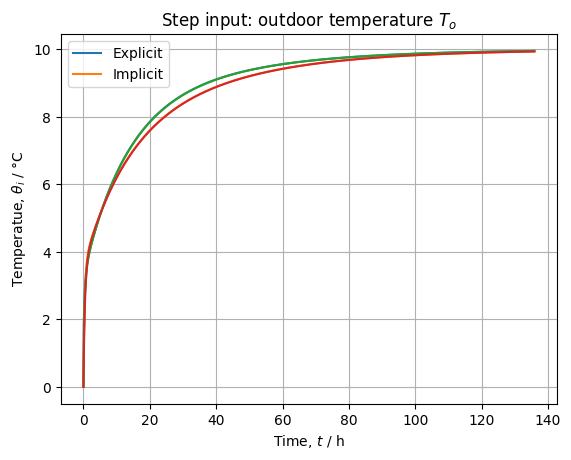

In [40]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

> Figure 4. Step response to outdoor temperature by using Euler

### 4. Simulation with weather data

#### a. Start and end time

In [41]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

In [42]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


#### b. Inputs

##### Read weather data

In [43]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

In [44]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

##### Solar irradiance on the walls

In [45]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)

pd.DataFrame(rad_surf)

,direct,diffuse,reflected
2000-01-03 12:00:00+01:00,5.423683,66.5,27.025936
2000-01-03 13:00:00+01:00,62.074669,75.0,34.289730
2000-01-03 14:00:00+01:00,66.175859,67.5,30.353167
2000-01-03 15:00:00+01:00,38.420856,42.0,17.456968
2000-01-03 16:00:00+01:00,0.000000,9.5,3.800000
...,...,...,...
2000-02-05 14:00:00+01:00,366.835007,63.0,55.437685
2000-02-05 15:00:00+01:00,206.374750,54.5,32.485083
2000-02-05 16:00:00+01:00,51.032277,39.5,15.800272
2000-02-05 17:00:00+01:00,0.000000,6.0,2.400000


The total solar irradiance $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [46]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

pd.DataFrame(rad_surf)


,direct,diffuse,reflected,Φtot
2000-01-03 12:00:00+01:00,5.423683,66.5,27.025936,98.949619
2000-01-03 13:00:00+01:00,62.074669,75.0,34.289730,171.364399
2000-01-03 14:00:00+01:00,66.175859,67.5,30.353167,164.029026
2000-01-03 15:00:00+01:00,38.420856,42.0,17.456968,97.877824
2000-01-03 16:00:00+01:00,0.000000,9.5,3.800000,13.300000
...,...,...,...,...
2000-02-05 14:00:00+01:00,366.835007,63.0,55.437685,485.272692
2000-02-05 15:00:00+01:00,206.374750,54.5,32.485083,293.359833
2000-02-05 16:00:00+01:00,51.032277,39.5,15.800272,106.332549
2000-02-05 17:00:00+01:00,0.000000,6.0,2.400000,8.400000


##### Resample the weather data

In [47]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

pd.DataFrame(data)

,To,Φtot
2000-01-03 12:00:00+01:00,6.800000,98.949619
2000-01-03 12:05:00+01:00,6.900000,104.984184
2000-01-03 12:10:00+01:00,7.000000,111.018749
2000-01-03 12:15:00+01:00,7.100000,117.053314
2000-01-03 12:20:00+01:00,7.200000,123.087879
...,...,...
2000-02-05 17:40:00+01:00,8.866667,2.800000
2000-02-05 17:45:00+01:00,8.725000,2.100000
2000-02-05 17:50:00+01:00,8.583333,1.400000
2000-02-05 17:55:00+01:00,8.441667,0.700000


##### Other inputs

In [48]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

pd.DataFrame(data)

,To,Φtot,Ti,Qa
2000-01-03 12:00:00+01:00,6.800000,98.949619,20.0,0.0
2000-01-03 12:05:00+01:00,6.900000,104.984184,20.0,0.0
2000-01-03 12:10:00+01:00,7.000000,111.018749,20.0,0.0
2000-01-03 12:15:00+01:00,7.100000,117.053314,20.0,0.0
2000-01-03 12:20:00+01:00,7.200000,123.087879,20.0,0.0
...,...,...,...,...
2000-02-05 17:40:00+01:00,8.866667,2.800000,20.0,0.0
2000-02-05 17:45:00+01:00,8.725000,2.100000,20.0,0.0
2000-02-05 17:50:00+01:00,8.583333,1.400000,20.0,0.0
2000-02-05 17:55:00+01:00,8.441667,0.700000,20.0,0.0


##### Input vector in time

In [49]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * Swall_out * data['Φtot']
Φi = τ_gSW * α_wSW * Sgw * data['Φtot']
Φa = α_gSW * Sgw * data['Φtot']

u = pd.concat([To, To, To, Ti, To, Φo, Φi, Φa], axis=1)
u.columns.values[[5, 6, 7]] = ['Φo', 'Φi', 'Φa']

pd.DataFrame(u)

,To,To,To,Ti,To,Φo,Φi,Φa
2000-01-03 12:00:00+01:00,6.800000,6.800000,6.800000,20.0,6.800000,3092.175597,74.212214,376.008553
2000-01-03 12:05:00+01:00,6.900000,6.900000,6.900000,20.0,6.900000,3280.755753,78.738138,398.939900
2000-01-03 12:10:00+01:00,7.000000,7.000000,7.000000,20.0,7.000000,3469.335910,83.264062,421.871247
2000-01-03 12:15:00+01:00,7.100000,7.100000,7.100000,20.0,7.100000,3657.916066,87.789986,444.802594
2000-01-03 12:20:00+01:00,7.200000,7.200000,7.200000,20.0,7.200000,3846.496222,92.315909,467.733941
...,...,...,...,...,...,...,...,...
2000-02-05 17:40:00+01:00,8.866667,8.866667,8.866667,20.0,8.866667,87.500000,2.100000,10.640000
2000-02-05 17:45:00+01:00,8.725000,8.725000,8.725000,20.0,8.725000,65.625000,1.575000,7.980000
2000-02-05 17:50:00+01:00,8.583333,8.583333,8.583333,20.0,8.583333,43.750000,1.050000,5.320000
2000-02-05 17:55:00+01:00,8.441667,8.441667,8.441667,20.0,8.441667,21.875000,0.525000,2.660000


#### c. Initial conditions

In [50]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])


#### d. Time integration

In [51]:
for k in range(u.shape[0] - 1 ):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

pd.DataFrame(θ_exp)

,0,1,2,3,4,5,6,7,8,9,...,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576
0,20.0,19.537584,19.216577,19.008759,18.892708,18.851039,18.869815,18.937653,19.045434,19.185701,...,14.454838,14.176395,13.927833,13.703468,13.498682,13.309730,13.133567,12.967725,12.810197,12.659358
1,20.0,19.985306,19.951812,19.915696,19.877277,19.838630,19.799197,19.760412,19.721798,19.684379,...,15.820431,15.782599,15.743789,15.703999,15.663335,15.621793,15.579449,15.536295,15.492389,15.447724
2,20.0,18.033459,17.691426,17.360794,17.226858,17.023276,16.956957,16.834587,16.811891,16.745015,...,13.237582,13.163148,13.082477,13.007680,12.928027,12.852593,12.773372,12.697159,12.617979,12.540917
3,20.0,18.900000,18.134614,17.752208,17.273513,17.046616,16.737552,16.609713,16.414951,16.351210,...,12.390816,12.307086,12.234266,12.153911,12.081449,12.003131,11.930515,11.853346,11.780281,11.703670
4,20.0,20.000000,19.381021,18.736063,18.296912,17.874729,17.599615,17.329145,17.161923,16.992788,...,11.926924,11.860731,11.791572,11.727477,11.660871,11.597794,11.532619,11.469887,11.405413,11.342609
5,20.0,19.979745,19.959705,19.938926,19.917371,19.895358,19.872916,19.850273,19.827435,19.804564,...,8.445183,8.452284,8.459043,8.465457,8.471535,8.477275,8.482682,8.487755,8.492498,8.496910


In [52]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

pd.DataFrame(y_exp)

,0,1,2,3,4,5,6,7,8,9,...,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576
0,20.0,18.033459,17.691426,17.360794,17.226858,17.023276,16.956957,16.834587,16.811891,16.745015,...,13.237582,13.163148,13.082477,13.007680,12.928027,12.852593,12.773372,12.697159,12.617979,12.540917
1,20.0,18.900000,18.134614,17.752208,17.273513,17.046616,16.737552,16.609713,16.414951,16.351210,...,12.390816,12.307086,12.234266,12.153911,12.081449,12.003131,11.930515,11.853346,11.780281,11.703670


In [53]:
data['θi_exp'] = y_exp[0].T
data['θibis_exp'] = y_exp[1].T

data['q_HVAC'] = q_HVAC.T

pd.DataFrame(data)

,To,Φtot,Ti,Qa,θi_exp,θibis_exp,q_HVAC
2000-01-03 12:00:00+01:00,6.800000,98.949619,20.0,0.0,20.000000,20.000000,0.0
2000-01-03 12:05:00+01:00,6.900000,104.984184,20.0,0.0,18.033459,18.900000,0.0
2000-01-03 12:10:00+01:00,7.000000,111.018749,20.0,0.0,17.691426,18.134614,0.0
2000-01-03 12:15:00+01:00,7.100000,117.053314,20.0,0.0,17.360794,17.752208,0.0
2000-01-03 12:20:00+01:00,7.200000,123.087879,20.0,0.0,17.226858,17.273513,0.0
...,...,...,...,...,...,...,...
2000-02-05 17:40:00+01:00,8.866667,2.800000,20.0,0.0,12.852593,12.003131,0.0
2000-02-05 17:45:00+01:00,8.725000,2.100000,20.0,0.0,12.773372,11.930515,0.0
2000-02-05 17:50:00+01:00,8.583333,1.400000,20.0,0.0,12.697159,11.853346,0.0
2000-02-05 17:55:00+01:00,8.441667,0.700000,20.0,0.0,12.617979,11.780281,0.0


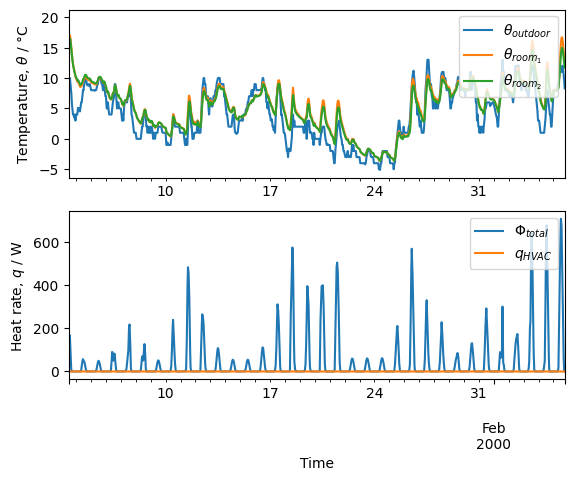

In [54]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp','θibis_exp' ]].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{room_1}$','$θ_{room_2}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 5. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

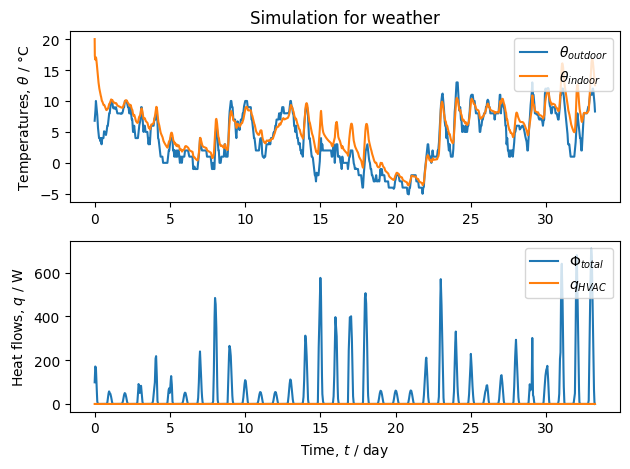

In [55]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Conclusion

During this project, we learned to simulate the thermodynamics of a house we designed. This model is based on choices we made. The model  could be improved by taking into account the air flowing between the rooms throught the door, or add a ventilation and a window in every room. However, with the choices made, we still have a valid model with coherent temperatures evolutions. 